In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import random
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

os.environ['PYTHONHASHSEED']=str(42)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

pd.set_option('display.max_colwidth', None)

In [2]:
stop_words = stopwords.words('english')
embed_dim = 300
batch_size = 256

In [3]:
# training data
train = pd.read_csv('train.csv.zip')
# testing data
test = pd.read_csv('test.csv.zip')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0


In [6]:
test.head()

,id,comment_text
0,00001cee341fdb12,"Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
1,0000247867823ef7,"== From RfC == \n\n The title is fine as it is, IMO."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the information I updated was the correct form. I can only guess the source hadn't updated. I shall update the information once again but thank you for your message."
4,00017695ad8997eb,I don't anonymously edit articles at all.


## check null values

In [7]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [8]:
# label column names
label_names = list(train.columns[2:])
label_names

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [9]:
label = train[['toxic', 'severe_toxic' , 'obscene' , 'threat' , 'insult' , 'identity_hate']]
label.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


## the frequency of each type of labels

In [10]:
ct0 = (label.astype(bool).sum(axis=1)==0).astype(bool).sum()
ct1 = (label.astype(bool).sum(axis=1)==1).astype(bool).sum()
ct2 = (label.astype(bool).sum(axis=1)>=2).astype(bool).sum()

print(f"samples having no label : {ct0}")
print(f"samples having exactly one label : {ct1}")
print(f"samples having 2 or more than 2 labels : {ct2}")

samples having no label : 143346
samples having exactly one label : 6360
samples having 2 or more than 2 labels : 9865


In [11]:
seq_len_series = train['comment_text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(seq_len_series.mean() + seq_len_series.std()).astype(int)

print(max_seq_len)

168


average length of comment: 394.073


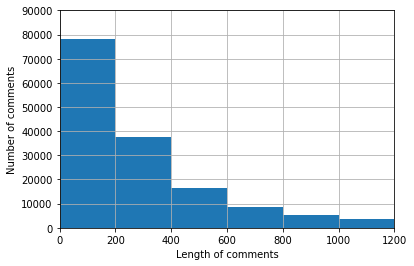

In [12]:
x = [len(train['comment_text'][i]) for i in range(train['comment_text'].shape[0])]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)) )
bins = [1, 200, 400, 600, 800, 1000, 1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

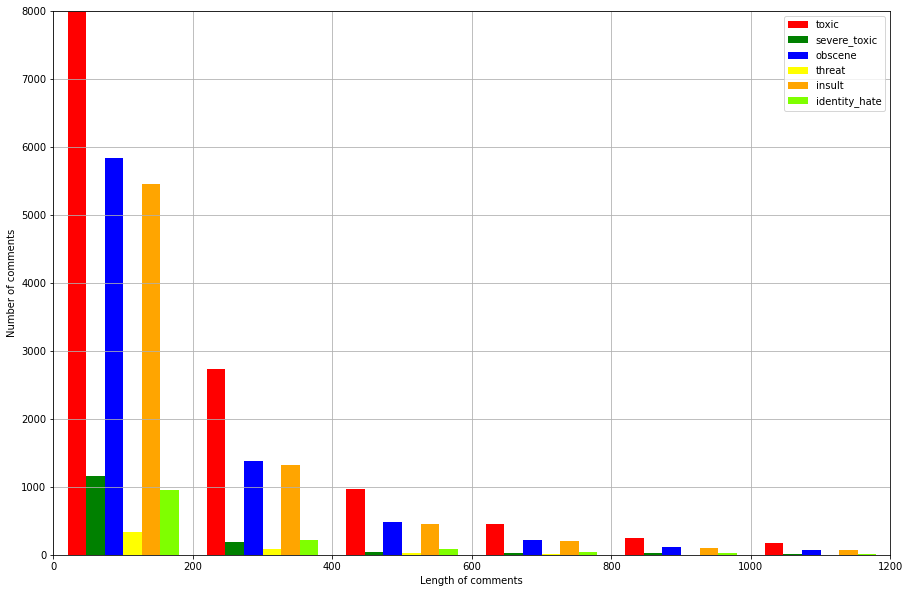

In [13]:
y = np.zeros(label.shape)
for ix in range(train['comment_text'].shape[0]):
    l = len(train['comment_text'][ix])
    if label['toxic'].iloc[ix] :
        y[ix][0] = l
    if label['severe_toxic'].iloc[ix] :
        y[ix][1] = l
    if label['obscene'].iloc[ix] :
        y[ix][2] = l
    if label['threat'].iloc[ix] :
        y[ix][3] = l
    if label['insult'].iloc[ix] :
        y[ix][4] = l
    if label['identity_hate'].iloc[ix] :
        y[ix][5] = l

labelsplt = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
color = ['red','green','blue','yellow','orange','chartreuse']  
plt.figure(figsize=(15, 10))
plt.hist(y, bins=bins, label=labelsplt, color=color)
plt.axis([0, 1200, 0, 8000])
plt.xlabel('Length of comments')
plt.ylabel('Number of comments') 
plt.legend()
plt.grid(True)
plt.show()

<BarContainer object of 6 artists>

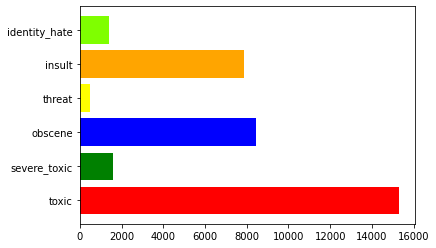

In [14]:
plt.barh(labelsplt, train[label_names].sum(axis = 0),color=color)

## text normalization

In [15]:
def to_lowercase(text):
    return text.lower()

# remove website links
def remove_links(text):
    template = re.compile(r'https?://\S+|www\.\S+') 
    text = template.sub(r'', text)
    return text

# remove HTML tags
def remove_html(text):
    template = re.compile(r'<[^>]*>') 
    text = template.sub(r'', text)
    return text

def text2words(text):
      return word_tokenize(text)

# remove stopwords
def remove_stopwords(words, stop_words):
    return [word for word in words if word not in stop_words]

# remove none ascii characters
def remove_non_ascii(text):
    template = re.compile(r'[^\x00-\x7E]+') 
    text = template.sub(r'', text)
    return text

# replace none printable characters
def remove_non_printable(text):
    template = re.compile(r'[\x00-\x0F]+') 
    text = template.sub(r' ', text)
    return text

# remove special characters
def remove_special_chars(text):
        text = re.sub("'s", '', text)
        template = re.compile('["#$%&\'()\*\+-/:;<=>@\[\]\\\\^_`{|}~]') 
        text = template.sub(r' ', text)
        return text

# replace multiple punctuation 
def replace_multiplt_punc(text):
        text = re.sub('[.!?]{2,}', '.', text)
        text = re.sub(',+', ',', text) 
        return text

# remove punctuation from list of tokenized words
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# remove numbers
def remove_numbers(text):
        text = re.sub('\d+', ' ', text)
        return text

def handle_spaces(text):
    # remove extra spaces
    text = re.sub('\s+', ' ', text)
    
    # remove spaces at the beginning and at the end of string
    text = text.strip() 
    
    return text

# lemmatize words in text
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

# lemmatize verbs in text
def lemmatize_verbs(words):
    lemmatizer = WordNetLemmatizer()
    return ([lemmatizer.lemmatize(word, pos='v') for word in words])

def remove_pattern(text): 
    # remove hi moron 
    text= re.sub(r'(hi)(.*)\1', r'\1', text)
    # remove duplicate words
    text= re.sub(r"\b(\w+)(?:\W+\1\b)+", r'\1', text, flags=re.IGNORECASE)
    # remove [User:Cirt]] 
    text= re.sub(r"\[.*?\]", ' ', text)
    # remove \n\n
    text= re.sub(r"\n", ' ', text)
    return text

def clean_text( text):
    text = remove_pattern(text)
    text = remove_links(text)
    text = remove_html(text)
    text = remove_special_chars(text)
    text = remove_non_ascii(text)
    text = remove_non_printable(text)
    text = remove_numbers(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    text = handle_spaces(text)
    words = text2words(text)
    words = remove_stopwords(words, stop_words)
    words = lemmatize_words(words)
    words = lemmatize_verbs(words)

    return ' '.join(words)

In [16]:
print(train['comment_text'].iloc[10])
print('\n************************* after cleaning text *************************\n')
sample_test = clean_text(train['comment_text'].iloc[10])
print(sample_test)

"
Fair use rationale for Image:Wonju.jpg

Thanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use.

Please go to the image description page and edit it to include a fair use rationale.

If you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of 'image' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such an explanat

In [17]:
def return_tweets(df):
    texts = [str(i) for i in df['comment_text'].tolist()]
    return texts

In [18]:
train_texts = return_tweets(train)
# test_texts = return_tweets(test)

In [19]:
train_texts = list(map(clean_text, train_texts))

average length of comment: 172.663


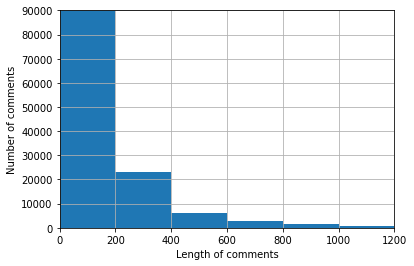

In [20]:
x = [len(train_texts[i]) for i in range(len(train_texts))]

print('average length of comment: {:.3f}'.format(sum(x)/len(x)))
bins = [1, 200, 400, 600, 800, 1000, 1200]
plt.hist(x, bins=bins)
plt.xlabel('Length of comments')
plt.ylabel('Number of comments')       
plt.axis([0, 1200, 0, 90000])
plt.grid(True)
plt.show()

## Tokenizing

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer

tok = Tokenizer(num_words=100000)
# tok.fit_on_texts(train_texts + test_texts)
tok.fit_on_texts(train_texts)

## fastText Embedding

In [22]:
import codecs

embeddings_index = {}
f = codecs.open('wiki.simple.vec', encoding='utf-8')
for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [23]:
words_not_found = []
nb_words = min(100000, len(tok.word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in tok.word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

## sequence padding

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

x_train = tok.texts_to_sequences(train_texts)
# x_test = tok.texts_to_sequences(test_texts)

training_padded = pad_sequences(
                    x_train,
                    maxlen=max_seq_len, 
                    truncating='post', 
                    padding='post')

# # test_texts
# test_padded = pad_sequences(
#                 x_test,
#                 maxlen=max_seq_len, 
#                 truncating='post', 
#                 padding='post')

## split dataset to train+val+test

In [25]:
y_train = np.asarray(label.values).astype('float32')

In [26]:
tr_X, test_X, tr_y, test_y = train_test_split(training_padded, y_train, train_size=0.80, random_state=42)
train_X, val_X, train_y, val_y = train_test_split(tr_X, tr_y, train_size=0.90, random_state=42)

In [27]:
print(train_X.shape)
print(train_y.shape)
print(val_X.shape)
print(val_y.shape)

(114890, 168)
(114890, 6)
(12766, 168)
(12766, 6)


## LSTM MODEL

In [28]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

In [29]:
tf.keras.backend.clear_session()

In [30]:
model_lstm = models.Sequential()
model_lstm.add(layers.Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len))
model_lstm.add(layers.LSTM(64))
model_lstm.add(layers.Dense(6, activation='sigmoid'))

2022-07-17 08:42:07.240928: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-17 08:42:08.846376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38238 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [31]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 168, 300)          30000000  
                                                                 
 lstm (LSTM)                 (None, 64)                93440     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 30,093,830
Trainable params: 30,093,830
Non-trainable params: 0
_________________________________________________________________


In [32]:
model_lstm.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['AUC'])

mcp_save = ModelCheckpoint('best_model_lstm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

history = model_lstm.fit(
            train_X,
            train_y,
            epochs=10,
            batch_size=batch_size, 
            validation_data=(val_X, val_y), 
            callbacks=[mcp_save, reduce_lr_loss])

# load and evaluate the best model version
model_lstm = models.load_model('best_model_lstm.hdf5')

Epoch 1/10


2022-07-17 08:42:11.894436: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-07-17 08:42:12.574999: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


449/449 [==============================] - 9s 13ms/step - loss: 0.1548 - auc: 0.7294 - val_loss: 0.1450 - val_auc: 0.7522 - lr: 0.0010
Epoch 2/10
449/449 [==============================] - 5s 11ms/step - loss: 0.1395 - auc: 0.7545 - val_loss: 0.1443 - val_auc: 0.7552 - lr: 0.0010
Epoch 3/10
449/449 [==============================] - 5s 11ms/step - loss: 0.1389 - auc: 0.7563 - val_loss: 0.1441 - val_auc: 0.7554 - lr: 0.0010
Epoch 4/10
449/449 [==============================] - 5s 11ms/step - loss: 0.1361 - auc: 0.7781 - val_loss: 0.1191 - val_auc: 0.9014 - lr: 0.0010
Epoch 5/10
449/449 [==============================] - 5s 11ms/step - loss: 0.0798 - auc: 0.9496 - val_loss: 0.0689 - val_auc: 0.9676 - lr: 0.0010
Epoch 6/10
449/449 [==============================] - 5s 11ms/step - loss: 0.0591 - auc: 0.9746 - val_loss: 0.0583 - val_auc: 0.9763 - lr: 0.0010
Epoch 7/10
449/449 [==============================] - 5s 11ms/step - loss: 0.0493 - auc: 0.9803 - val_loss: 0.0554 - val_auc: 0.9734 - 

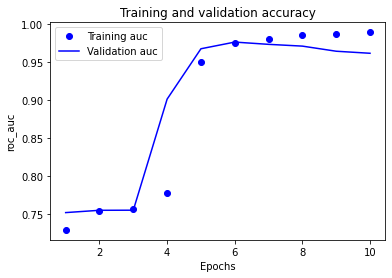

In [33]:
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'b', label='Validation auc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

In [34]:
y_pred = model_lstm.predict(test_X)
y_pred

array([[5.7770051e-03, 3.0825649e-05, 8.2756049e-04, 2.6191873e-04,
        1.0481267e-03, 5.1135535e-04],
       [2.3918129e-03, 1.6025075e-05, 4.1539138e-04, 1.8524552e-04,
        5.1964627e-04, 3.1572665e-04],
       [5.5445032e-03, 2.9842531e-05, 8.0146478e-04, 2.5701380e-04,
        1.0125185e-03, 4.9967505e-04],
       ...,
       [3.0287751e-03, 1.8868292e-05, 4.9945340e-04, 1.9975180e-04,
        6.1994971e-04, 3.5807342e-04],
       [8.8796544e-01, 1.6646445e-02, 3.6729038e-01, 2.1431845e-02,
        4.2276850e-01, 6.3560136e-02],
       [2.8247328e-03, 1.7963190e-05, 4.7291504e-04, 1.9506573e-04,
        5.8792561e-04, 3.4477102e-04]], dtype=float32)

In [35]:
y_pred_fixed = (y_pred >= 0.5)
y_pred_fixed = np.multiply(y_pred_fixed, 1.0)
y_pred_fixed

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [36]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_pred_fixed, target_names=label_names, zero_division=1))

               precision    recall  f1-score   support

        toxic       0.78      0.75      0.76      3056
 severe_toxic       0.75      0.05      0.09       321
      obscene       0.89      0.66      0.76      1715
       threat       1.00      0.00      0.00        74
       insult       0.77      0.59      0.67      1614
identity_hate       1.00      0.00      0.00       294

    micro avg       0.80      0.62      0.70      7074
    macro avg       0.86      0.34      0.38      7074
 weighted avg       0.82      0.62      0.67      7074
  samples avg       0.98      0.96      0.94      7074



## CNN-LSTM MODEL

In [37]:
tf.keras.backend.clear_session()

In [38]:
model_cnn_lstm = models.Sequential()
model_cnn_lstm.add(layers.Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len))
model_cnn_lstm.add(layers.Conv1D(filters=16, kernel_size=3))
model_cnn_lstm.add(layers.MaxPooling1D())
model_cnn_lstm.add(layers.LSTM(64))
model_cnn_lstm.add(layers.Dense(6, activation='sigmoid'))

In [39]:
model_cnn_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 168, 300)          30000000  
                                                                 
 conv1d (Conv1D)             (None, 166, 16)           14416     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 83, 16)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 30,035,542
Trainable params: 30,035,542
Non-trainable params: 0
____________________________________________

In [40]:
model_cnn_lstm.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['AUC'])

mcp_save = ModelCheckpoint('best_model_cnn_lstm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

history = model_cnn_lstm.fit(
            train_X,
            train_y,
            epochs=10,
            batch_size=batch_size, 
            validation_data=(val_X, val_y), 
            callbacks=[mcp_save, reduce_lr_loss])

# load and evaluate the best model version
model_cnn_lstm = models.load_model('best_model_cnn_lstm.hdf5')

Epoch 1/10


2022-07-17 08:43:10.131095: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-17 08:43:10.131844: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-17 08:43:10.131858: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-17 08:43:10.132333: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-17 08:43:10.132383: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


449/449 [==============================] - 7s 10ms/step - loss: 0.1549 - auc: 0.7292 - val_loss: 0.1449 - val_auc: 0.7520 - lr: 0.0010
Epoch 2/10
449/449 [==============================] - 4s 9ms/step - loss: 0.1396 - auc: 0.7537 - val_loss: 0.1446 - val_auc: 0.7542 - lr: 0.0010
Epoch 3/10
449/449 [==============================] - 4s 9ms/step - loss: 0.1395 - auc: 0.7546 - val_loss: 0.1446 - val_auc: 0.7539 - lr: 0.0010
Epoch 4/10
449/449 [==============================] - 4s 9ms/step - loss: 0.1390 - auc: 0.7554 - val_loss: 0.1443 - val_auc: 0.7554 - lr: 0.0010
Epoch 5/10
449/449 [==============================] - 4s 9ms/step - loss: 0.1300 - auc: 0.8049 - val_loss: 0.0827 - val_auc: 0.9492 - lr: 0.0010
Epoch 6/10
449/449 [==============================] - 4s 9ms/step - loss: 0.0629 - auc: 0.9669 - val_loss: 0.0562 - val_auc: 0.9769 - lr: 0.0010
Epoch 7/10
449/449 [==============================] - 4s 9ms/step - loss: 0.0468 - auc: 0.9820 - val_loss: 0.0538 - val_auc: 0.9736 - lr: 0.

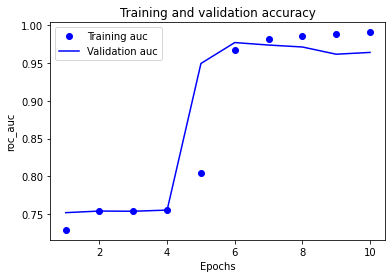

In [41]:
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'b', label='Validation auc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

In [42]:
y_pred = model_cnn_lstm.predict(test_X)
y_pred

array([[6.0964260e-02, 3.3502129e-04, 8.6313402e-03, 1.5087432e-03,
        1.2083280e-02, 2.7409953e-03],
       [2.2656627e-03, 7.2503091e-05, 7.1361783e-04, 3.1721406e-04,
        5.1792496e-04, 3.5894633e-04],
       [8.8913552e-03, 1.1499399e-04, 1.7118711e-03, 4.6340749e-04,
        1.7274858e-03, 6.8326300e-04],
       ...,
       [2.0598569e-03, 7.5858159e-05, 6.8799505e-04, 3.4679077e-04,
        4.8841059e-04, 3.7211442e-04],
       [8.8727957e-01, 2.1176929e-02, 5.4852110e-01, 2.0659685e-02,
        4.6947137e-01, 6.1695982e-02],
       [2.4351568e-03, 7.5138712e-05, 7.2990032e-04, 3.2744190e-04,
        5.4790446e-04, 3.7377427e-04]], dtype=float32)

In [43]:
y_pred_fixed = (y_pred >= 0.5)
y_pred_fixed = np.multiply(y_pred_fixed, 1.0)
y_pred_fixed

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [44]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_pred_fixed, target_names=label_names, zero_division=1))

               precision    recall  f1-score   support

        toxic       0.78      0.78      0.78      3056
 severe_toxic       0.68      0.04      0.08       321
      obscene       0.78      0.82      0.80      1715
       threat       1.00      0.00      0.00        74
       insult       0.69      0.71      0.70      1614
identity_hate       1.00      0.00      0.00       294

    micro avg       0.75      0.70      0.73      7074
    macro avg       0.82      0.39      0.39      7074
 weighted avg       0.76      0.70      0.69      7074
  samples avg       0.97      0.96      0.94      7074



## Bi-Directional LSTM MODEL

In [45]:
tf.keras.backend.clear_session()

In [46]:
model_bi_lstm = models.Sequential()
model_bi_lstm.add(layers.Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len))
model_bi_lstm.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))
model_bi_lstm.add(layers.Bidirectional(layers.LSTM(64)))
model_bi_lstm.add(layers.Dense(6, activation='sigmoid'))

In [47]:
model_bi_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 168, 300)          30000000  
                                                                 
 bidirectional (Bidirectiona  (None, 168, 128)         186880    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 30,286,470
Trainable params: 30,286,470
Non-trainable params: 0
_________________________________________________________________


In [48]:
model_bi_lstm.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['AUC'])

mcp_save = ModelCheckpoint('best_model_bi_lstm.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

history = model_bi_lstm.fit(
            train_X,
            train_y,
            epochs=10,
            batch_size=batch_size, 
            validation_data=(val_X, val_y), 
            callbacks=[mcp_save, reduce_lr_loss])

# load and evaluate the best model version
model_bi_lstm = models.load_model('best_model_bi_lstm.hdf5')

Epoch 1/10
449/449 [==============================] - 19s 32ms/step - loss: 0.0863 - auc: 0.9392 - val_loss: 0.0522 - val_auc: 0.9765 - lr: 0.0010
Epoch 2/10
449/449 [==============================] - 13s 29ms/step - loss: 0.0469 - auc: 0.9816 - val_loss: 0.0498 - val_auc: 0.9777 - lr: 0.0010
Epoch 3/10
449/449 [==============================] - 13s 29ms/step - loss: 0.0398 - auc: 0.9871 - val_loss: 0.0500 - val_auc: 0.9789 - lr: 0.0010
Epoch 4/10
449/449 [==============================] - 13s 29ms/step - loss: 0.0338 - auc: 0.9907 - val_loss: 0.0520 - val_auc: 0.9722 - lr: 0.0010
Epoch 5/10
449/449 [==============================] - 13s 29ms/step - loss: 0.0291 - auc: 0.9929 - val_loss: 0.0561 - val_auc: 0.9668 - lr: 0.0010
Epoch 6/10
449/449 [==============================] - 13s 29ms/step - loss: 0.0250 - auc: 0.9945 - val_loss: 0.0610 - val_auc: 0.9593 - lr: 0.0010
Epoch 7/10
449/449 [==============================] - 13s 29ms/step - loss: 0.0214 - auc: 0.9955 - val_loss: 0.0649 - 

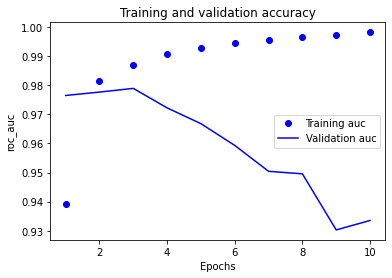

In [49]:
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'b', label='Validation auc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

In [50]:
y_pred = model_bi_lstm.predict(test_X)
y_pred

array([[1.94677766e-02, 2.66059244e-04, 2.72335671e-03, 7.80212111e-04,
        2.36176513e-03, 7.19284406e-04],
       [1.48225739e-03, 1.14567905e-04, 5.78468200e-04, 3.02582543e-04,
        3.78463796e-04, 2.53295671e-04],
       [1.24905109e-02, 2.40271722e-04, 1.91009964e-03, 7.06223131e-04,
        1.74325984e-03, 5.89036150e-04],
       ...,
       [1.56081410e-03, 1.09260123e-04, 5.98071958e-04, 3.00675107e-04,
        3.78893543e-04, 2.42737777e-04],
       [8.89355004e-01, 1.89431477e-02, 3.10521364e-01, 3.14164087e-02,
        3.84013861e-01, 6.89834580e-02],
       [2.85795890e-03, 1.40433374e-04, 1.02902518e-03, 3.65349610e-04,
        6.39220991e-04, 3.18795122e-04]], dtype=float32)

In [51]:
y_pred_fixed = (y_pred >= 0.5)
y_pred_fixed = np.multiply(y_pred_fixed, 1.0)
y_pred_fixed

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [52]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_pred_fixed, target_names=label_names, zero_division=1))

               precision    recall  f1-score   support

        toxic       0.83      0.74      0.78      3056
 severe_toxic       0.67      0.14      0.23       321
      obscene       0.84      0.76      0.80      1715
       threat       1.00      0.00      0.00        74
       insult       0.75      0.60      0.67      1614
identity_hate       1.00      0.00      0.00       294

    micro avg       0.81      0.65      0.72      7074
    macro avg       0.85      0.37      0.41      7074
 weighted avg       0.82      0.65      0.69      7074
  samples avg       0.98      0.96      0.95      7074



## Bi-directional GRU

In [53]:
tf.keras.backend.clear_session()

In [54]:
model_bi_gru = models.Sequential()
model_bi_gru.add(layers.Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len))
model_bi_gru.add(layers.Bidirectional(layers.GRU(64, return_sequences=True)))
model_bi_gru.add(layers.Bidirectional(layers.GRU(64)))
model_bi_gru.add(layers.Dense(16, activation='relu'))
model_bi_gru.add(layers.Dense(6, activation='sigmoid'))

In [55]:
model_bi_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 168, 300)          30000000  
                                                                 
 bidirectional (Bidirectiona  (None, 168, 128)         140544    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 6)                 102       
                                                                 
Total params: 30,217,206
Trainable params: 30,217,206
No

In [56]:
model_bi_gru.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['AUC'])

mcp_save = ModelCheckpoint('best_model_bi_gru.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

history = model_bi_gru.fit(
            train_X,
            train_y,
            epochs=10,
            batch_size=batch_size, 
            validation_data=(val_X, val_y), 
            callbacks=[mcp_save, reduce_lr_loss])

# load and evaluate the best model version
model_bi_gru = models.load_model('best_model_bi_gru.hdf5')

Epoch 1/10
449/449 [==============================] - 21s 34ms/step - loss: 0.0799 - auc: 0.9481 - val_loss: 0.0505 - val_auc: 0.9790 - lr: 0.0010
Epoch 2/10
449/449 [==============================] - 14s 32ms/step - loss: 0.0439 - auc: 0.9843 - val_loss: 0.0470 - val_auc: 0.9801 - lr: 0.0010
Epoch 3/10
449/449 [==============================] - 14s 31ms/step - loss: 0.0363 - auc: 0.9894 - val_loss: 0.0486 - val_auc: 0.9786 - lr: 0.0010
Epoch 4/10
449/449 [==============================] - 14s 31ms/step - loss: 0.0299 - auc: 0.9927 - val_loss: 0.0528 - val_auc: 0.9711 - lr: 0.0010
Epoch 5/10
449/449 [==============================] - 14s 31ms/step - loss: 0.0243 - auc: 0.9948 - val_loss: 0.0605 - val_auc: 0.9626 - lr: 0.0010
Epoch 6/10
449/449 [==============================] - 14s 31ms/step - loss: 0.0187 - auc: 0.9967 - val_loss: 0.0693 - val_auc: 0.9452 - lr: 0.0010
Epoch 7/10
449/449 [==============================] - 14s 31ms/step - loss: 0.0143 - auc: 0.9978 - val_loss: 0.0784 - 

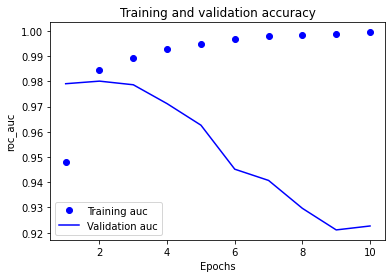

In [57]:
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'b', label='Validation auc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

In [58]:
y_pred = model_bi_gru.predict(test_X)
y_pred

array([[3.0075416e-02, 2.2768351e-04, 3.0534810e-03, 1.4998113e-03,
        4.0139346e-03, 6.5588945e-04],
       [1.2387997e-03, 3.9728620e-05, 3.6317765e-04, 1.8914034e-04,
        2.1042871e-04, 5.0554339e-05],
       [1.1244582e-02, 1.3137910e-04, 1.6833384e-03, 7.8989088e-04,
        1.5945400e-03, 2.1386756e-04],
       ...,
       [7.8091648e-04, 3.2228643e-05, 2.5798625e-04, 1.4439005e-04,
        1.4373260e-04, 3.2594726e-05],
       [8.7992901e-01, 1.1199212e-02, 2.2554454e-01, 1.9669322e-02,
        3.9444306e-01, 9.1489796e-03],
       [2.3094576e-03, 5.6728895e-05, 5.4761837e-04, 2.4063645e-04,
        3.2976925e-04, 6.3422442e-05]], dtype=float32)

In [59]:
y_pred_fixed = (y_pred >= 0.5)
y_pred_fixed = np.multiply(y_pred_fixed, 1.0)
y_pred_fixed

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [60]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_pred_fixed, target_names=label_names, zero_division=1))

               precision    recall  f1-score   support

        toxic       0.84      0.73      0.78      3056
 severe_toxic       0.61      0.21      0.31       321
      obscene       0.84      0.79      0.82      1715
       threat       1.00      0.00      0.00        74
       insult       0.74      0.64      0.69      1614
identity_hate       0.71      0.14      0.23       294

    micro avg       0.81      0.67      0.73      7074
    macro avg       0.79      0.42      0.47      7074
 weighted avg       0.80      0.67      0.72      7074
  samples avg       0.98      0.96      0.95      7074



## CNN with Conv1D layers

In [61]:
tf.keras.backend.clear_session()

In [62]:
model_cnn = models.Sequential()
model_cnn.add(layers.Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_seq_len))
model_cnn.add(layers.Conv1D(filters=32, kernel_size=5))
model_cnn.add(layers.MaxPooling1D())
model_cnn.add(layers.Conv1D(filters=16, kernel_size=3))
model_cnn.add(layers.MaxPooling1D())
model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(6, activation='sigmoid'))

In [63]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 168, 300)          30000000  
                                                                 
 conv1d (Conv1D)             (None, 164, 32)           48032     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 82, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 80, 16)            1552      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 40, 16)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 640)               0

In [64]:
model_cnn.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['AUC'])

mcp_save = ModelCheckpoint('best_model_cnn.hdf5', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

history = model_cnn.fit(
            train_X,
            train_y,
            epochs=10,
            batch_size=batch_size, 
            validation_data=(val_X, val_y), 
            callbacks=[mcp_save, reduce_lr_loss])

# load and evaluate the best model version
model_cnn = models.load_model('best_model_cnn.hdf5')

Epoch 1/10
449/449 [==============================] - 4s 8ms/step - loss: 0.0982 - auc: 0.9178 - val_loss: 0.0625 - val_auc: 0.9679 - lr: 0.0010
Epoch 2/10
449/449 [==============================] - 3s 7ms/step - loss: 0.0534 - auc: 0.9779 - val_loss: 0.0591 - val_auc: 0.9718 - lr: 0.0010
Epoch 3/10
449/449 [==============================] - 3s 7ms/step - loss: 0.0424 - auc: 0.9876 - val_loss: 0.0593 - val_auc: 0.9683 - lr: 0.0010
Epoch 4/10
449/449 [==============================] - 3s 6ms/step - loss: 0.0330 - auc: 0.9926 - val_loss: 0.0645 - val_auc: 0.9573 - lr: 0.0010
Epoch 5/10
449/449 [==============================] - 3s 6ms/step - loss: 0.0254 - auc: 0.9952 - val_loss: 0.0697 - val_auc: 0.9562 - lr: 0.0010
Epoch 6/10
449/449 [==============================] - 3s 6ms/step - loss: 0.0191 - auc: 0.9968 - val_loss: 0.0777 - val_auc: 0.9415 - lr: 0.0010
Epoch 7/10
449/449 [==============================] - 3s 6ms/step - loss: 0.0144 - auc: 0.9973 - val_loss: 0.0897 - val_auc: 0.927

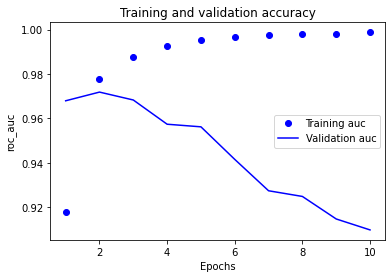

In [65]:
acc = history.history['auc']
val_acc = history.history['val_auc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training auc')
plt.plot(epochs, val_acc, 'b', label='Validation auc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('roc_auc')
plt.legend()

plt.show()

In [66]:
y_pred = model_cnn.predict(test_X)
y_pred

array([[3.1002779e-02, 3.4282613e-03, 1.1930143e-02, 7.4088150e-03,
        1.7622145e-02, 1.5328729e-02],
       [4.2636305e-04, 8.5081992e-05, 3.7416711e-04, 4.3904179e-04,
        5.3102279e-04, 2.8991862e-04],
       [1.0128438e-01, 7.7142543e-03, 2.9563384e-02, 1.1656334e-02,
        3.3563767e-02, 1.1855153e-02],
       ...,
       [1.7295308e-04, 1.3535896e-04, 1.4704524e-04, 2.4607280e-04,
        9.6850033e-04, 2.9478059e-04],
       [7.9816282e-01, 5.1338866e-02, 3.6706311e-01, 2.5286010e-02,
        2.8634053e-01, 3.7856564e-02],
       [2.2695528e-03, 2.3547299e-03, 7.8946501e-03, 3.0709154e-03,
        2.5755824e-03, 2.9285094e-03]], dtype=float32)

In [67]:
y_pred_fixed = (y_pred >= 0.5)
y_pred_fixed = np.multiply(y_pred_fixed, 1.0)
y_pred_fixed

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [68]:
from sklearn.metrics import classification_report

print(classification_report(test_y, y_pred_fixed, target_names=label_names, zero_division=1))

               precision    recall  f1-score   support

        toxic       0.87      0.67      0.75      3056
 severe_toxic       0.48      0.28      0.36       321
      obscene       0.85      0.72      0.78      1715
       threat       0.27      0.11      0.15        74
       insult       0.75      0.59      0.66      1614
identity_hate       0.31      0.07      0.12       294

    micro avg       0.81      0.61      0.70      7074
    macro avg       0.59      0.41      0.47      7074
 weighted avg       0.79      0.61      0.69      7074
  samples avg       0.98      0.95      0.94      7074

